In [1]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt

from utils.parse_pars import parse_pars
from spamm.run_spamm import spamm
import run_fe, run_pl, run_bc, run_hg, run_ne
from utils.add_in_quadrature import add_in_quadrature
from spamm.analysis import plot_best_models
from spamm.Samples import Samples

In [2]:
def goodpixels_util(lam, spectral_mask):
    flag = np.zeros_like(lam, dtype=bool)
    for mask in spectral_mask:
        left, right = mask[0], mask[1]
        flag |= (lam > left) & (lam < right)
    
    return ~flag

In [3]:
# This should be a wllength range from 1000-10,000A, every 0.5A
TEST_wl = parse_pars()["testing"]

# Create wllength array from min, max and step values
wl = np.arange(TEST_wl["wl_min"], TEST_wl["wl_max"], TEST_wl["wl_step"])

# These values were picked by hand to provide the most realistic power law.
PL_PARAMS = {"norm_PL": 5e-15,
             "slope1": 2.3,
             "broken_pl": False,
             "wl": wl}

# The normalizations are drawn from a gaussian sample with mu=9.06e-15,
# sigma=3.08946e-15 (from 0->template max flux). fe_width is halfway 
# between range in parameters. wl is very close to template span (1075-7535)
FE_PARAMS = {"fe_norm_1": 1.07988504e-14,
             "fe_norm_2": 6.91877436e-15,
             "fe_norm_3": 5e-15,# 8.68930476e-15, 
             "fe_width": 5450,
             "no_templates": 3,
             "wl": wl}

# These values are just the midpoints of the parameter space in parameters.yaml
BC_PARAMS = {"bc_norm": 3e-14,
             "bc_tauBE": 1.,
             "bc_logNe": 5.5,
             "bc_loffset": 0.,
             "bc_lwidth": 5050.,
             "bc_Te": 15250.,
             "bc_lines": 201.5,
             "wl": wl}

# These values are just the midpoints of the parameter space in parameters.yaml
HG_PARAMS = {"hg_norm_1": 4e-16,
             "hg_norm_2": 2e-16,
             "hg_stellar_disp": 515,
             "no_templates": 2,
             "wl": wl}

NEL_PARAMS = {"width": 300, 
              "amp_1": 5e-14, 
              "center_1": 4830,
              "amp_2": 8e-14, 
              "center_2": 6800,
              "amp_3": 15e-14, 
              "center_3": 3000,
              "wl": wl}

LINEOUT = "#"*75

In [4]:
def generate_data(components=None, comp_params=None):

    all_wls = []
    all_fluxes = []
    all_errs = []
    comb_p = {}
    comp_names = {}
    
    for component in components:
        component = component.upper()
        if component == "PL":
            comp_wl, comp_flux, comp_err, comp_p = run_pl.create_pl(comp_params["PL"])
            comp_names["PL"] = True
            
        elif component == "FE":
            comp_wl, comp_flux, comp_err, comp_p = run_fe.create_fe(comp_params["FE"])
            comp_names["FE"] = True
            
        elif component == "BC" or component == "BPC":
            comp_wl, comp_flux, comp_err, comp_p = run_bc.create_bc(comp_params["BC"])
            comp_names["BC"] = True
            comp_names["BpC"] = True
            
        elif component == "HG" or component == "HG":
            comp_wl, comp_flux, comp_err, comp_p = run_hg.create_hg(comp_params["HG"])
            comp_names["HG"] = True

        elif component == "NEL":
            comp_wl, comp_flux, comp_err, comp_p = run_ne.create_ne(comp_params["NEL"])
            comp_names["NEL"] = True
            
        all_fluxes.append(comp_flux)
        all_wls.append(comp_wl)
        all_errs.append(comp_err)
        comb_p = {**comb_p, **comp_p}

    comb_wl = wl
    comb_flux = np.sum(all_fluxes, axis=0)
    comb_err = add_in_quadrature(all_errs)
    
    #print(f"{LINEOUT}\nUsing components: {components}")
    
    return comb_wl, comb_flux, comb_err, all_fluxes, comp_names

[1000.  1000.5 1001.  ... 9998.5 9999.  9999.5]


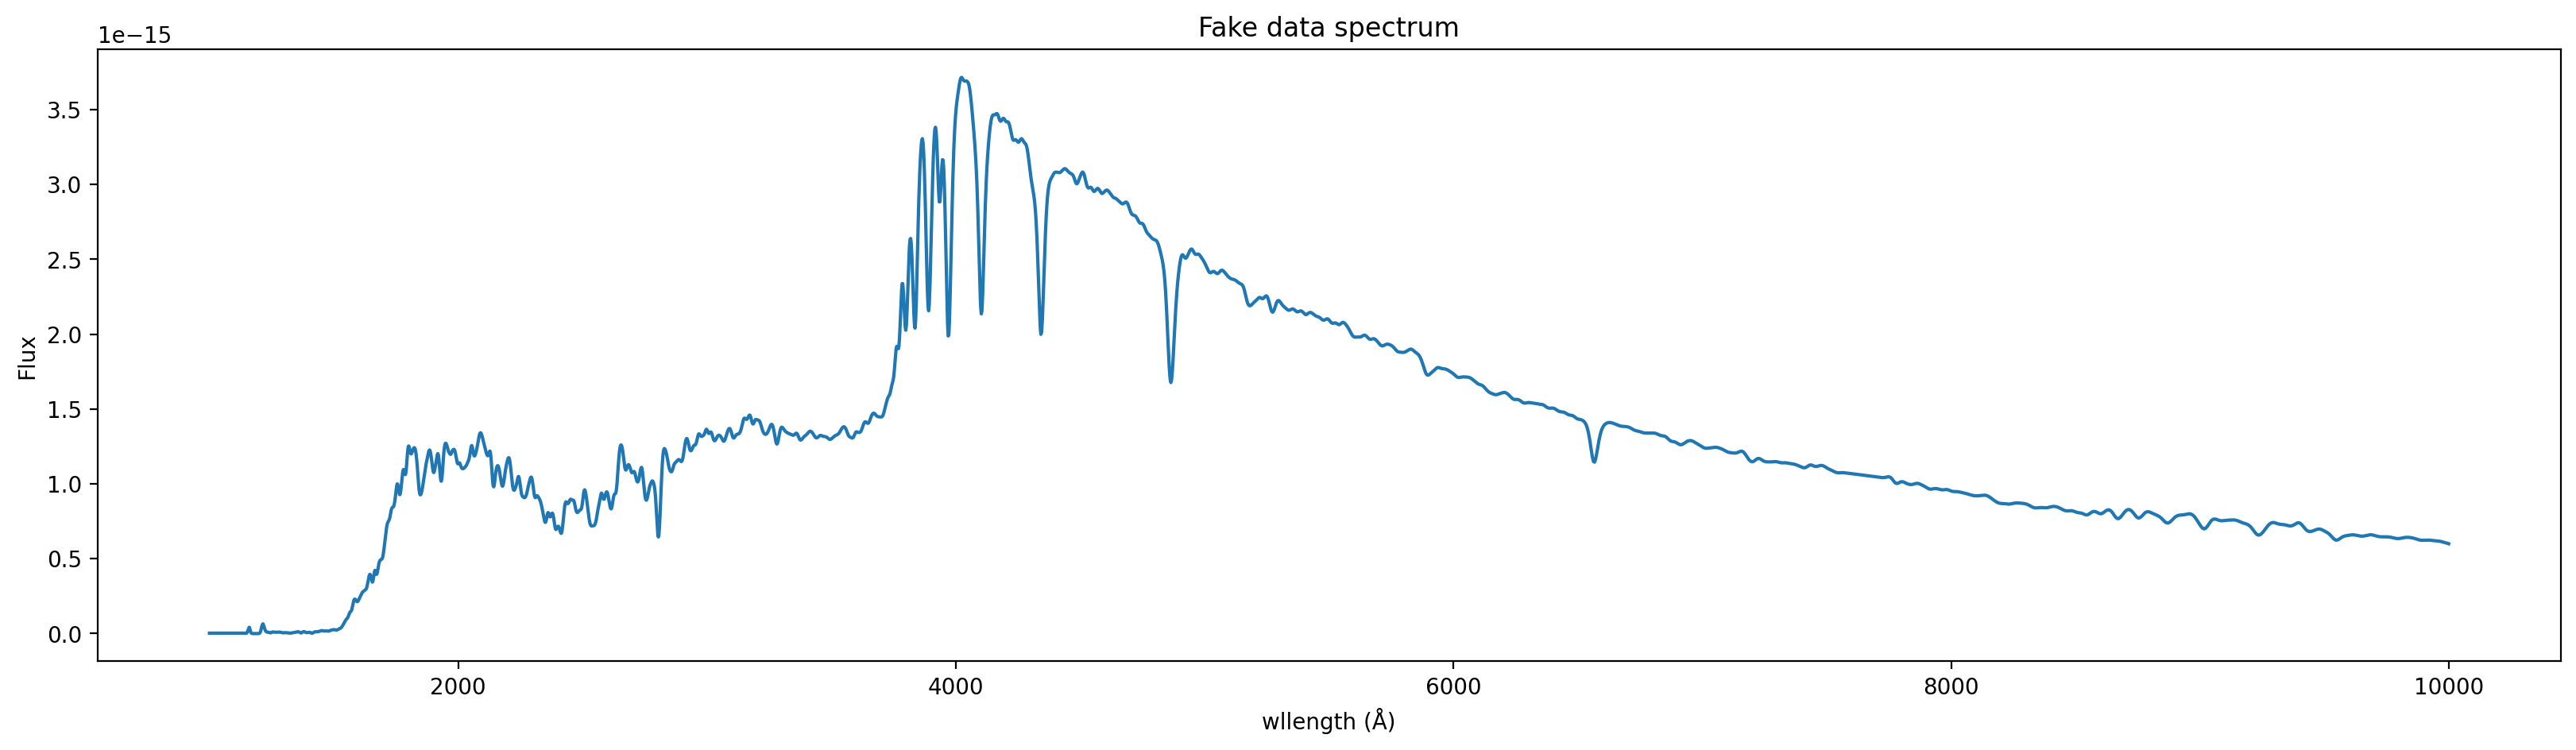

In [5]:
components=["PL", "HG", "BC", "FE"]
comp_params={"PL": PL_PARAMS, "HG": HG_PARAMS, "BC": BC_PARAMS, "FE": FE_PARAMS}

components=["PL", "BC"]
comp_params={"PL": PL_PARAMS, "BC": BC_PARAMS}

components=["HG"]
comp_params={"HG": HG_PARAMS}

#components=["PL"]
#comp_params={"PL": PL_PARAMS}

wl, flux, flux_err, all_fluxes, comp_names = generate_data(components=components, comp_params=comp_params)

fig = plt.figure(figsize=(20,5))
plt.plot(wl, flux)
plt.title(f"Fake data spectrum")
plt.xlabel("wllength (Å)")
plt.ylabel("Flux");

In [6]:
#components = ["PL"]
#comp_params = {"PL": PL_PARAMS}
#comp_names = {'PL': True}
mask = [(-10, 2000)]

In [7]:
spamm(complist=comp_names, inspectrum=(wl, flux, flux_err), mask=mask, comp_params=comp_params, n_walkers=32, n_iterations=150, 
      outdir="combined_example", picklefile="combined", parallel=False)

100%|█████████████████████████████████████████| 150/150 [00:05<00:00, 28.07it/s]


[SPAMM]: Mean acceptance fraction: 0.411
[SPAMM]: Saved pickle file: combined_example/combined.pickle.gz
[SPAMM]: Saved combined_triangle.png
[SPAMM]: Saved combined_chain.png
[SPAMM]: Saved combined_posterior.png
[SPAMM]: Execution time: 6.191 seconds


{'model': <spamm.Model.Model at 0x127e41f50>,
 'comp_params': {'HG': {'hg_norm_1': 4e-16,
   'hg_norm_2': 2e-16,
   'hg_stellar_disp': 515,
   'no_templates': 2},
  'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5]),
  'flux': array([2.75934458e-18, 2.75934458e-18, 2.75934458e-18, ...,
         6.00662523e-16, 6.00331253e-16, 6.00000000e-16]),
  'err': array([1.37967229e-19, 1.37967229e-19, 1.37967229e-19, ...,
         3.00331261e-17, 3.00165627e-17, 3.00000000e-17]),
  'components': {'PL': False,
   'FE': False,
   'HG': True,
   'BC': False,
   'BPC': False,
   'NEL': False,
   'CALZETTI_EXT': False,
   'SMC_EXT': False,
   'MW_EXT': False,
   'AGN_EXT': False,
   'LMC_EXT': False}}}

In [8]:
S = Samples("combined_example/combined.pickle.gz", outdir='combined_example', burn=50)
S.means
plot_best_models(S)

[False False False ...  True  True  True]
[(1000.0, 1999.5)]
[SPAMM]: Saved combined_bestfits.png
